In [83]:
''' 1. Zipcodes to ZCTAs mapping
This script maps every US zipcode to its corresponding ZCTA as mapped
by US Bureau of Statistics

2. Socio-economic classification of Zipcodes/ZCTAs
using K-Means Clustering Algorithm by household income
''' 
# Authour Diana Kung'u

from pandas import read_csv, merge, read_excel, ExcelFile, concat
import numpy as np

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import  squarify # Treemap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [84]:
#Read Data
#zctas dataframe with household income
zctas = read_csv('.\Input\ZCTA_Household_income.csv') 

# zipcode - zcta mapping dataframe
with ExcelFile(r'.\Input\ZiptoZcta_Crosswalk_2021.xlsx') as xl :
    df = concat([read_excel(xl, sheet_name = s ) for s in xl.sheet_names],
                ignore_index= True)


##### Data pre-processing.

In [85]:
df.ZCTA = df.ZCTA.astype('str') #Convert ZCTA from int to string

print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41107 unique values.
df.ZCTA dtype: object, with 33144 unique values.


In [86]:
#Check the length of ZCTA codes
df['len'] = df.ZCTA.str.len()
df['len'].unique() # There are  3,5 and 7 character long ZCTAs codes
df[df['len'] == 7] # This represent 'No ZCTA' ZCTA (drop)	
df.drop(df[df['len'] == 7].index, inplace= True)

#Add leading 0s to ZCTAs of len 3 or 4
df.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
            for c in df.ZCTA]

print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41099 unique values.
df.ZCTA dtype: object, with 33139 unique values.


In [87]:
zctas.ZCTA = zctas.ZCTA.astype('str')
print(f'ZCTA dtype: {zctas.ZCTA.dtype} with {zctas.ZCTA.nunique()} unique values')

# Convert all ZCTAs to 5 digit
zctas.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in zctas.ZCTA]


ZCTA dtype: object with 33120 unique values


In [88]:
#Merge zctas and df: zipcode_zctas codes mapping dataframe
df = df.iloc[:, [0,2,4]].copy()
df = df.drop_duplicates(keep='last')

df = df.merge(zctas, how='right', left_on= 'ZCTA', right_on= 'ZCTA')

In [89]:
#convert zip_codes to 5-digit str object
df.ZIP_CODE = df.ZIP_CODE.astype('Int64') 
df.drop(df[df.ZIP_CODE.isna()].index, inplace= True) # drop rows with missing zipcodes
df.ZIP_CODE = df.ZIP_CODE.astype('str')
df.ZIP_CODE = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in df.ZIP_CODE]
df.head(3)

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3
0,35007,AL,35007,2224,473,254,9,8,7
1,35137,AL,35007,2224,473,254,9,8,7
2,35144,AL,35007,2224,473,254,9,8,7


#### K-Means Classification

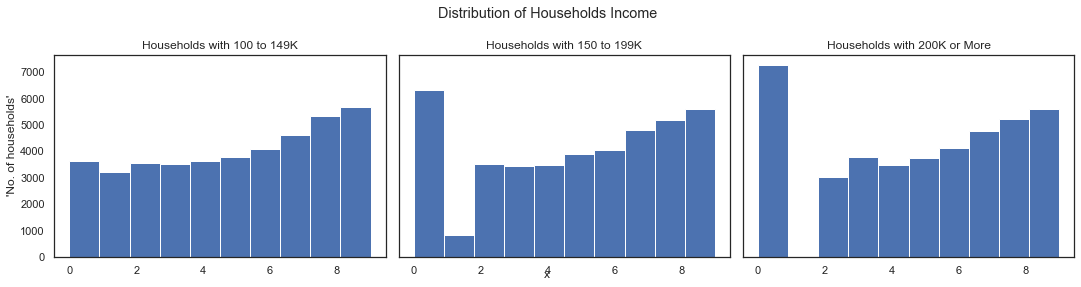

In [90]:
#Distribution of RFM 1, RFM 2 and RFM 3
figure, axs = plt.subplots(1, 3,figsize=(15, 4), facecolor='w', edgecolor='k',
                            sharey= True, tight_layout=True)

axs[0].hist(df.RFM1, bins=10)
axs[1].hist(df.RFM2, bins=10)
axs[2].hist(df.RFM3, bins=10)
plt.suptitle('Distribution of Households Income')
figure.text(0.5, 0.04, "x", ha = 'center')
figure.text(0.0, 0.5, "'No. of households'", va = 'center', rotation = 'vertical')

income_labels = ['100 to 149K', '150 to 199K', '200K or More']
for i in range(3):
    plt.subplot(1, 3, i+1).set_title(f'Households with {income_labels[i]}')


In [91]:
#Check the skew
df.skew()
#RFM1, RFM2, RFM3 are fairly neautral

ZIP_CODE                0.069315
ZCTA                    0.070028
Households100to149K     2.018696
Households150to199K     2.743939
Households200KorMore    4.431109
RFM1                   -0.222285
RFM2                   -0.271716
RFM3                   -0.291696
dtype: float64

##### Find number of clusters with Elbow Method.

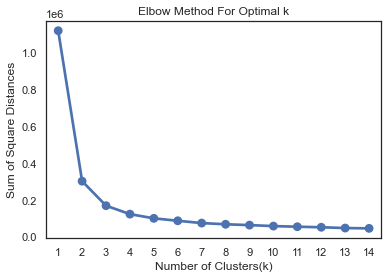

In [92]:
scaled_data = df[['RFM1', 'RFM2', 'RFM3']]

sum_of_sq_dist = {} # Sum of squared errors
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(scaled_data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [93]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 5000)
KMean_clust.fit(scaled_data)

#Find the clusters for the observation given in the dataset
df['Cluster'] = KMean_clust.labels_
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,Cluster
0,35007,AL,35007,2224,473,254,9,8,7,1
1,35137,AL,35007,2224,473,254,9,8,7,1
2,35144,AL,35007,2224,473,254,9,8,7,1
3,35124,AL,35124,2012,809,805,9,8,8,1
4,35173,AL,35173,2265,1037,980,9,9,9,1


In [94]:
#Map clusters to status labels
class_dict = {0: 'upper', 1: 'middle', 2: 'lower'}
df['Status'] = df.Cluster.map(class_dict)
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,Cluster,Status
0,35007,AL,35007,2224,473,254,9,8,7,1,middle
1,35137,AL,35007,2224,473,254,9,8,7,1,middle
2,35144,AL,35007,2224,473,254,9,8,7,1,middle
3,35124,AL,35124,2012,809,805,9,8,8,1,middle
4,35173,AL,35173,2265,1037,980,9,9,9,1,middle


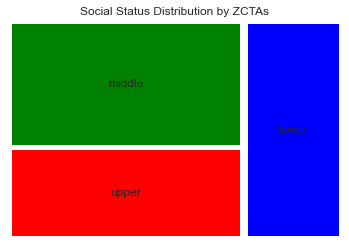

Status
lower     12134
middle    16862
upper     12070
Name: Cluster, dtype: int64

In [95]:
#Treemap: Distribution of clusters
labels = ['upper', 'middle',  'lower']
color = ['red', 'green', 'blue', ]
df_classes = df.groupby('Status')['Cluster'].count()

squarify.plot(df_classes.values,
              color=color, label= labels, pad = True)
plt.title('Social Status Distribution by ZCTAs')
plt.axis('off')
plt.show()
df_classes

In [97]:
cols = ['ZIP_CODE', 'ZCTA', 'STATE', 'Status']
df.to_csv('zipcodes_zcta_classified.csv', index = False, columns=cols)